Number of sentences: 63
Sample sentence: the house the only one in the entire valley sat on the crest of a low hill
Vocabulary size: 406
Number of sequences: 971
Max sequence length: 39
X shape: (971, 38)
y shape: (971,)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.0064 - loss: 6.0516 - val_accuracy: 0.0103 - val_loss: 5.9132
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.0326 - loss: 5.7093 - val_accuracy: 0.1077 - val_loss: 5.8359
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.0588 - loss: 5.4968 - val_accuracy: 0.1077 - val_loss: 5.7668
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.0680 - loss: 5.3930 - val_accuracy: 0.1077 - val_loss: 5.7154
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.0774 - loss: 5.3652 - val_accuracy: 0.1077 - val_loss: 5.6886
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.0709 - loss: 5.2869 - val_accuracy: 0.1077 - val_loss: 5.7432
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.0675 - loss: 5.2495 - val_accuracy: 0.1077 - val_loss: 5.7810
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.0596 - loss: 5.3231 - val_accur

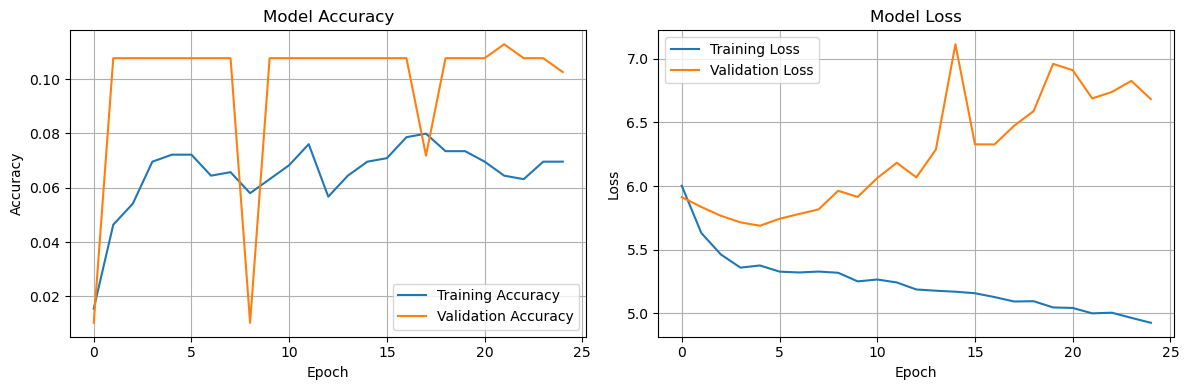


TESTING THE MODEL

Single word predictions:
'the' -> 'the the'
'lencho' -> 'lencho are'
'god' -> 'god for'
'the postmaster' -> 'the postmaster when'
'money' -> 'money field'
'rain' -> 'rain even'
'the field' -> 'the field a'
'he wrote' -> 'he wrote a'

TOP-5 PREDICTIONS

Seed text: 'the'
  the: 1.82%
  to: 1.75%
  a: 1.19%
  he: 1.14%
  and: 0.93%

Seed text: 'lencho'
  the: 1.82%
  to: 1.75%
  a: 1.19%
  he: 1.14%
  and: 0.93%

Seed text: 'god'
  the: 1.82%
  to: 1.75%
  a: 1.19%
  he: 1.14%
  and: 0.93%

TEXT GENERATION
Seed: 'the man'

Temperature 0.3:
  the man a the one the an and a wrote to nothing

Temperature 0.7:
  the man downpour they there postman office began slightest to with new



Temperature 1.0:
  the man did broke to goodwill surprise were money work for his

Model and tokenizer saved successfully!


In [ ]:
# =========================
# 1. Imports
# =========================
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import random

# =========================
# 2. Raw Text
# =========================
faqs = """
"""

# =========================
# 3. Text Cleaning
# =========================

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s\.]', '', text)
    text = re.sub(r'\s+', ' ', text)
    sentences = text.split('.')
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

sentences = clean_text(faqs)
print(f"Number of sentences: {len(sentences)}")
print(f"Sample sentence: {sentences[0]}")

# =========================
# 4. Tokenization
# =========================
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

# =========================
# 5. Create Input–Output Pairs (Improved)
# =========================
input_sequences = []

for sentence in sentences:
    tokenized = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(tokenized)):
        n_gram_sequence = tokenized[:i+1]
        input_sequences.append(n_gram_sequence)

print(f"Number of sequences: {len(input_sequences)}")

# =========================
# 6. Padding
# =========================
max_len = max([len(seq) for seq in input_sequences])
print(f"Max sequence length: {max_len}")

input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_len, padding='pre'))

# Split into features and labels
X = input_sequences[:, :-1]
y = input_sequences[:, -1]

print("X shape:", X.shape)
print("y shape:", y.shape)

# =========================
# 7. Train-Test Split
# =========================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================
# 8. Model Architecture
# =========================
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len-1),
    
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    
    LSTM(64),
    Dropout(0.3),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(vocab_size, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

# =========================
# 9. Callbacks
# =========================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# =========================
# 10. Training
# =========================
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# =========================
# 11. Plot Training History
# =========================
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# =========================
# 12. Prediction Functions
# =========================
def predict_next_word(model, tokenizer, text, max_len, num_words=1, temperature=0.7):
    """
    Predict next word with temperature-based sampling
    """
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([text])[0]
        token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
        
        # Get predictions
        predicted_probs = model.predict(token_list, verbose=0)[0]
        
        predicted_probs = np.log(predicted_probs + 1e-7) / temperature
        exp_probs = np.exp(predicted_probs)
        predicted_probs = exp_probs / np.sum(exp_probs)
        
        predicted_index = np.random.choice(range(len(predicted_probs)), p=predicted_probs)
        
        # Convert index to word
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        
        text += " " + output_word
    
    return text

def get_top_predictions(model, tokenizer, text, max_len, top_k=5):
    """
    Get top-k predictions with confidence scores
    """
    token_list = tokenizer.texts_to_sequences([text])[0]
    token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
    
    predictions = model.predict(token_list, verbose=0)[0]
    
    # Get top-k indices
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    
    results = []
    for idx in top_indices:
        word = ""
        for w, i in tokenizer.word_index.items():
            if i == idx:
                word = w
                break
        confidence = predictions[idx] * 100
        results.append((word, confidence))
    
    return results

# =========================
# 13. Test the Model
# =========================
# Test with various seed texts
test_seeds = [
    "sherlock homes"
]

print("\nSingle word predictions:")
for seed in test_seeds:
    prediction = predict_next_word(model, tokenizer, seed, max_len, num_words=1, temperature=0.5)
    print(f"'{seed}' -> '{prediction}'")

print("\n" + "="*50)
print("TOP-5 PREDICTIONS")
print("="*50)

for seed in test_seeds[:3]:  # Test first 3 seeds
    print(f"\nSeed text: '{seed}'")
    top_predictions = get_top_predictions(model, tokenizer, seed, max_len, top_k=5)
    for word, confidence in top_predictions:
        print(f"  {word}: {confidence:.2f}%")

print("\n" + "="*50)
print("TEXT GENERATION")
print("="*50)

# Generate longer text with different temperatures
seed_text = "the man"
print(f"Seed: '{seed_text}'")

for temp in [0.3, 0.7, 1.0]:
    generated = predict_next_word(model, tokenizer, seed_text, max_len, num_words=10, temperature=temp)
    print(f"\nTemperature {temp}:")
    print(f"  {generated}")

# =========================
# 14. Interactive Testing
# =========================
def interactive_predictor():
    print("\n" + "="*50)
    print("INTERACTIVE NEXT WORD PREDICTOR")
    print("Enter 'quit' to exit")
    print("="*50)
    
    while True:
        seed = input("\nEnter seed text: ").lower()
        if seed == 'quit':
            break
        
        # Show top predictions
        top_preds = get_top_predictions(model, tokenizer, seed, max_len, top_k=5)
        print("\nTop 5 predictions:")
        for word, conf in top_preds:
            print(f"  {word}: {conf:.2f}%")
        
        # Generate continuation
        generated = predict_next_word(model, tokenizer, seed, max_len, num_words=5, temperature=0.7)
        print(f"\nContinuation: {generated}")

# Uncomment to run interactive mode
# interactive_predictor()

# =========================
# 15. Save Model
# =========================
model.save('next_word_model_final.h5')
import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle)

print("\nModel and tokenizer saved successfully!")

# =========================
# 16. Load and Test Saved Model
# =========================
def load_and_test_model():
    # Load model
    loaded_model = tf.keras.models.load_model('next_word_model_final.h5')
    
    # Load tokenizer
    with open('tokenizer.pkl', 'rb') as handle:
        loaded_tokenizer = pickle.load(handle)
    
    print("\nLoaded model successfully!")
    
    # Test with known phrases from the text
    test_phrases = [
        "who is sherlock "
        
    ]
    
    print("\nTesting loaded model:")
    for phrase in test_phrases:
        next_word = predict_next_word(loaded_model, loaded_tokenizer, phrase, max_len, num_words=1, temperature=0.5)
        print(f"'{phrase}' -> '{next_word}'")



In [ ]:
# =========================
# NEXT WORD PREDICTOR - Simplified Version
# =========================

import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import random

# =========================
# 1. TEXT DATA (Your story)
text_data
with open('dataForNextWordPredictor.txt') as f:
    text_data=f.read()
# =========================


# =========================
# 2. DATA PREPROCESSING
# =========================

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters but keep spaces and periods
    text = re.sub(r'[^a-zA-Z\s\.]', '', text)
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    # Split into sentences
    sentences = text.split('.')
    # Remove empty sentences
    sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
    return sentences

sentences = preprocess_text(text_data)
print(f"Total sentences: {len(sentences)}")
print(f"Sample sentence: {sentences[0][:50]}...")

# =========================
# 3. TOKENIZATION
# =========================
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1
print(f"Total unique words: {total_words}")

# =========================
# 4. CREATE SEQUENCES
# =========================
input_sequences = []
for sentence in sentences:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print(f"Total sequences created: {len(input_sequences)}")

# =========================
# 5. PAD SEQUENCES
# =========================
max_sequence_len = max([len(seq) for seq in input_sequences])
print(f"Maximum sequence length: {max_sequence_len}")

input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Split into features and labels
X = input_sequences[:, :-1]
y = input_sequences[:, -1]

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# =========================
# 6. TRAIN-TEST SPLIT
# =========================
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# =========================
# 7. BUILD MODEL
# =========================


model = Sequential([
    
    Embedding(total_words, 100, input_length=max_sequence_len-1),
    Bidirectional(LSTM(200, dropout=0.2, return_sequences=False)),
    Dense(total_words, activation='softmax')
])


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(model.summary())

# =========================
# 8. TRAIN MODEL
# =========================

early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# =========================
# 9. PLOT TRAINING RESULTS
# =========================
print("\n" + "=" * 50)
print("STEP 6: Training Results")
print("=" * 50)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =========================
# 10. PREDICTION FUNCTION
# =========================
print("\n" + "=" * 50)
print("STEP 7: Testing Predictions")
print("=" * 50)

def predict_next_words(model, tokenizer, text, num_words=3):
    """
    Predict the next words given a seed text
    """
    for _ in range(num_words):
        # Convert text to sequence
        token_list = tokenizer.texts_to_sequences([text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        # Get predictions
        predicted_probs = model.predict(token_list, verbose=0)[0]
        
        # Get the word with highest probability
        predicted_index = np.argmax(predicted_probs)
        
        # Convert index to word
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        
        text += " " + output_word
    
    return text

# Test the model
test_phrases = [
    "the",
    "lencho",
    "god",
    "rain",
    "post office"
]

print("\nPredictions:")
for phrase in test_phrases:
    prediction = predict_next_words(model, tokenizer, phrase, num_words=2)
    print(f"'{phrase}' -> '{prediction}'")

# =========================
# 11. INTERACTIVE MODE
# =========================
print("\n" + "=" * 50)
print("STEP 8: Interactive Predictor")
print("=" * 50)
print("Type 'quit' to exit")

while True:
    user_input = input("\nEnter a word or phrase: ").lower()
    
    if user_input == 'quit':
        break
    
    if user_input.strip() == "":
        continue
    
    # Make prediction
    prediction = predict_next_words(model, tokenizer, user_input, num_words=3)
    print(f"Next words: {prediction}")

